In [22]:
# Built-in modules
import math

# Imports from Qiskit
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit.circuit.library import GroverOperator, MCMT, ZGate
from qiskit.visualization import plot_distribution

In [8]:
def grover_oracle(marked_states):
    """Build a Grover oracle for multiple marked states

    Here we assume all input marked states have the same number of bits

    Parameters:
        marked_states (str or list): Marked states of oracle

    Returns:
        QuantumCircuit: Quantum circuit representing Grover oracle
    """
    if not isinstance(marked_states, list):
        marked_states = [marked_states]
    # Compute the number of qubits in circuit
    num_qubits = len(marked_states[0])

    qc = QuantumCircuit(num_qubits)
    # Mark each target state in the input list
    for target in marked_states:
        # Flip target bit-string to match Qiskit bit-ordering
        rev_target = target[::-1]
        # Find the indices of all the '0' elements in bit-string
        zero_inds = [ind for ind in range(num_qubits) if rev_target.startswith("0", ind)]
        # Add a multi-controlled Z-gate with pre- and post-applied X-gates (open-controls)
        # where the target bit-string has a '0' entry
        qc.x(zero_inds)
        qc.compose(MCMT(ZGate(), num_qubits - 1, 1), inplace=True)
        qc.x(zero_inds)
    return qc

/tmp/ipykernel_15623/2149212773.py:27: DeprecationWarning: The class ``qiskit.circuit.library.generalized_gates.mcmt.MCMT`` is deprecated as of Qiskit 1.4. It will be removed no earlier than 3 months after the release date. Use MCMTGate instead.
  qc.compose(MCMT(ZGate(), num_qubits - 1, 1), inplace=True)


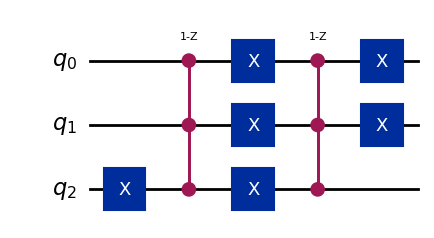

In [9]:
## a specific instance of a Grover search problem

marked_states = ["011", "100"]

oracle = grover_oracle(marked_states)
oracle.draw(output="mpl", style="iqp")

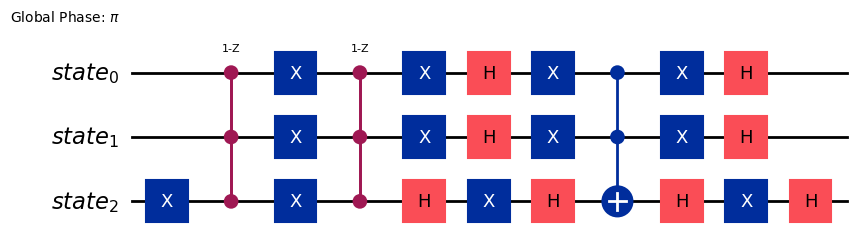

In [10]:
## the Grover operator given the oracle

grover_op = GroverOperator(oracle)
grover_op.decompose().draw(output="mpl", style="iqp")

Following is based on $t=\lfloor\frac{\pi}{4\theta}\rfloor$

In [11]:
optimal_num_iterations = math.floor(
    math.pi / (4 * math.asin(math.sqrt(len(marked_states) / 2**grover_op.num_qubits)))
)

print(f"t = {optimal_num_iterations}")

t = 1


In [15]:
print(f"Number of qubits: {grover_op.num_qubits}")

Number of qubits: 3


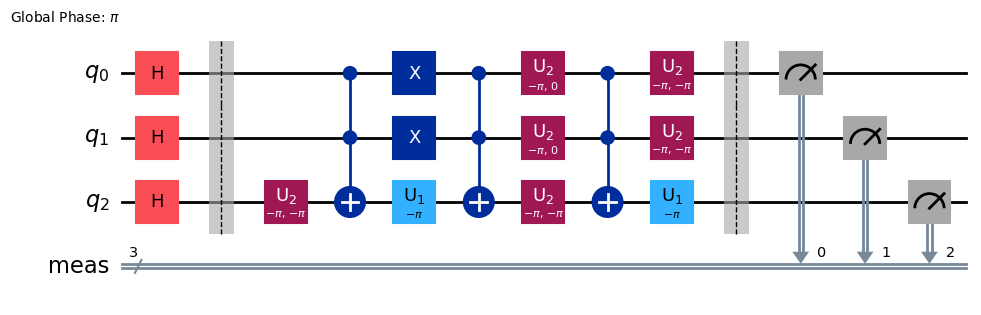

In [23]:
from qiskit.visualization import plot_histogram

qc = QuantumCircuit(grover_op.num_qubits)
qc.h(range(grover_op.num_qubits))
qc.barrier()

for i in range(optimal_num_iterations):
    qc.append(grover_op, range(grover_op.num_qubits))

qc.measure_all()

qc = transpile(qc, AerSimulator(), optimization_level=3)

display(qc.draw(output="mpl", style="iqp"))

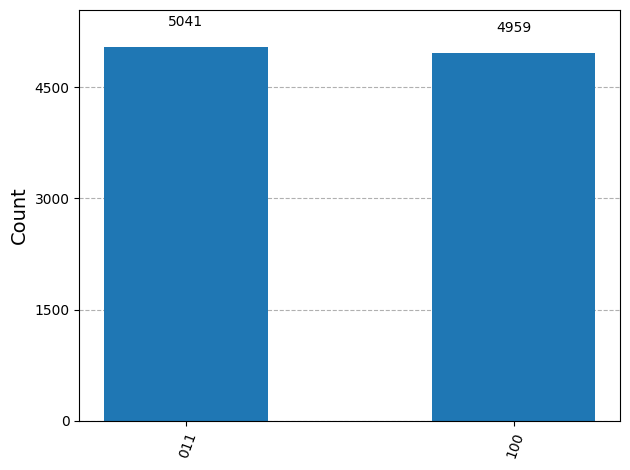

In [25]:
result = AerSimulator().run(qc, shots=10000).result()
statistics = result.get_counts()
display(plot_histogram(statistics))